<center><img src="http://what-when-how.com/wp-content/uploads/2012/07/tmp26dc139_thumb.png" width=50% > </center>

# <center> Assignment 2: Neighborhood Processing & Filters </center>
<center> Computer Vision 1 University of Amsterdam </center>
    <center> Due 23:59PM, September 24, 2022 (Amsterdam time) </center>
    
***

## General guidelines
Your code and discussion must be completed in this **jupyter notebook** before the deadline by submitting it to the Canvas Lab 2 Assignment. Submit your assignment in a **zip file**, with all the relevant files and images need to run your notebook. Name your zip file as follows:  **StudentID1_StudentID2_StudentID3.zip**
For full credit, make sure you follow these guidelines:

- Make sure you use the provided python environment. You can create the environment using conda and the provided YAML file using the following command: `conda env create --file=CV1_env.yaml`, then activate it as `conda activate cv1`. Using different packages versions may result in the impossibility to run the submitted code and therefore in the subtraction of points. Below you will find a code cell to check the versions of your packages. 
- Please express your thoughts concisely. The number of words does not necessarily correlate with how well you understand the concepts.
- Answer all given questions.
- Try to understand the problem as much as you can. When answering a question, give evidences (qualitative and/or quantitative results, references to papers, figures etc.) to support your arguments. Note that not everything might be explicitly asked for and you are expected to think about what might strengthen you arguments and make your notebook self-contained and complete.
- Analyze your results and discuss them, e.g. why algorithm A works better than algorithm B in a certain problem.
- Tables and figures must be accompanied by a brief description. Do not forget to add a number, a title, and if applicable name and unit of variables in a table, name and unit of axes and legends in a figure.
- Make sure all the code in your notebook runs without errors or bugs before submitting. Code that does not run can result in a lower grade. 

Late submissions are not allowed. Assignments that are submitted after the strict deadline will not be graded. In case of submission conflicts, TAs’ system clock is taken as reference. We strongly recommend submitting well in advance, to avoid last minute system failure issues.
Plagiarism note: Keep in mind that plagiarism (submitted materials which are not your work) is a serious crime and any misconduct shall be punished with the university regulations.

In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
import time
import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import scipy
from scipy import signal as sp
from scipy.signal import convolve2d
import requests

In [2]:
# Make sure you're using the provided environment!
assert cv2.__version__ == "3.4.2", "You're not using the provided Python environment!"
assert np.__version__ == "1.19.5", "You're not using the provided Python environment!"
assert matplotlib.__version__ == "3.3.4", "You're not using the provided Python environment!"
assert sklearn.__version__ == "0.23.0"

# Proceed to the next cell only if you don't get any error.


# 1 Introduction 


In this assignment, you will get familiar with fundamentals of neighborhood processing for image processing. These techniques allow for low-level image understanding via extraction of structural patterns such as edges and blobs. Similarly, they find an extensive use in image denoising and higher level image reasoning such as shape recognition. Moreover, neighborhood or block processing is one of the key components of *Convolutional Neural Networks*. Therefore, a good understanding of these
procedures will be a stepping stone towards understanding more complex machinery used in computer vision and machine learning.

In subsequent sections of this assignment, we will first explain neighborhood processing and introduce low-level filters commonly used to analyze images. After that, we will see how these mathematical concepts relate to practice by working through fundamental tasks such as denoising and segmentation. By the end of this assignment, you will have an overall understanding of the following:
* Gaussian and Gabor filters
* Edge detection and image denoising
* Texture-based image segmentation


---


First we need two helper functions 

In [3]:
### Use this for the last exercise

'''
    Loads an image, resizes image with proper resize factor and sets proper color representation
    :param image_id: id of an image: Kobi, Polar, Robin-1, Robin-2, Cows, SciencePark
    :return: image
'''

def load_image(image_id: str='Polar'):
    if image_id == 'Kobi':
        img = cv2.imread('./sample_data/sample_data/kobi.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resize_factor = 0.25
    elif image_id == 'Polar':
        img = cv2.imread('./sample_data/sample_data/polar-bear-hiding.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resize_factor = 0.75
    elif image_id == 'Robin-1':
        img = cv2.imread('./sample_data/sample_data/robin-1.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resize_factor = 1
    elif image_id == 'Robin-2':
        img = cv2.imread('./sample_data/sample_data/robin-2.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resize_factor = 0.5
    elif image_id == 'Cows':
        img = cv2.imread('./sample_data/sample_data/cows.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resize_factor = 0.5
    elif image_id == 'SciencePark':
        img = cv2.imread('./sample_data/sample_data/sciencepark.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resize_factor = 0.2
    else:
        raise ValueError('Image not available.')

    img = cv2.resize(img, (0, 0), fx=resize_factor, fy=resize_factor)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    return img

In [4]:
'''Displays image in grey scale'''
def show_image(image, image_title:str= "Polar", cmap='gray'):
    plt.figure()
    plt.title(image_title)
    plt.imshow(image, cmap=cmap)
    plt.axis("off")

# 2 Neighborhood Processing


Neighborhood processing is simply about looking around a point $I(x, y)$ (i.e. pixel) in the image, $I$, and applying a function, $h(k, l)$, which measures certain properties or relationships between the pixels in that localized window. The function, $h(k, l)$, is generally referred to as the neighborhood operator or local operator. One of the most common forms of a neighborhood operator is a linear filter. Linear filters simply compute the weighted sum of neighboring pixel intensities and assign it to the pixel of interest (output $I_{out}(i, j)$). The filters in which we are interested here are usually represented as a square matrix.

---
**Hint**: Filters, kernels, weight matrices or masks are interchangeably used in the literature. A kernel is a matrix with which we describe a neighborhood operation. This operation can, for example, be edge detection or smoothing.

---

Linear filters are shifted over the entire image plane via operators such as correlation ($\otimes$) and convolution ($\ast$). Both of these operators are *linear shift-invariant* (LSI) implying that the filters behave the same way over the entire image. Discrete forms of these operators are given in the following:


Correlation (1):
<center>
$\mathbf{I}_{out} = I \otimes  \mathbf{h}\\
 \mathbf{I}_{out}(i,j) = \sum_{k,l}  \mathbf{I}(i+k,j+l) \mathbf{h}(k,l)$
</center>
Convolution (2):
<center>
$    \mathbf{I}_{out} = \mathbf{I} \ast  \mathbf{h}\\
 \mathbf{I}_{out}(i,j) = \sum_{k,l} \mathbf{I}(i-k,j-l) \mathbf{h}(k,l)$
 </center>


---
The following example illustrates the overall idea of neighborhood processing. The kernel or the mask convolves over the input image. In the case of linear filters, this is simply multiplying each pixel intensity with the corresponding weight in the kernel (see the yellowish $7x7$ window where the kernel is placed). In the example, the kernel is $7x7$ averaging mask. You can see its effect by comparing the red (before filtering) and the green (after filtering) frames.





**Example:**
![](https://drive.google.com/uc?export=view&id=1HXt-WTi2Mg-jHYU4tvcKl4R29gi-g1QY)

### Question (10 pts)
1.   What is the difference between correlation and convolution operators? How do they treat the signals $\mathbf{I}$ and $\mathbf{h}$?
2.   Correlation and convolution operators are equivalent when we make an assumption on the form of the mask $\mathbf{h}$. Can you identify the case?


<span style="color:red">Answer: </span>

1. In neighborhood processing a certain function is applied on a pixel by looking at its neighbors, and measuring certain properties or relations between pixels in this 'window' or 'kernel' of neighboring pixels. One of the most common of these operators is the linear filter. This filter is shifted over the entire image via operators such as 'correlation' or 'convolution'. As can already be concluded from the formulas in which way these operators work, they are very similar. Convolution can be seen as correlation with 'flipped filters'. When we are applying a function $h(k,l)$ on a localized window $I$; for correlation the function will be applied on $I(i+k, j+l)$; whereas for convolution the function will be applied on $I(i-k, j-l)$.

2. We described earlier that convolution can be seen as correlation with 'flipped filters', this means that correlation and convolution yield the same result when we have a filter $h(k,l)$ which is point symmetric!

# 3 Low-level filters


In this section, you will design common linear filters used in neighborhood processing. We will focus in particular on Gaussian and Gabor filters.

## 3.1 Gaussian Filters

### 3.1.1 1D Gaussian Filter



The 1D  Gaussian filter is defined as follows:
<center>
$ G_{\sigma}(x)=\frac{1}{\sigma\sqrt{2\pi}}\text{ exp}(-\frac{x^2}{2\sigma^2}),$
</center>
where $\sigma$ is the variance of the Gaussian. However, such formulation creates an infinitely large convolution kernel. In practice, the kernel is truncated with a `kernel_size` parameter such that $-\left\lfloor \frac{kernel\_size}{2}\right\rfloor \leq x \leq \left\lfloor \frac{kernel\_size}{2} \right\rfloor$, where $\left\lfloor . \right\rfloor$ is the floor operator. As an example, if `kernel_size` equals 3, $x \in \{ -1, 0, 1 \} $.

### Exercise 
Now, implement the following *gauss1D* function.

**Hint:** 
Do not forget to normalize your filter.

**Note:** You are not allowed to use a Python built-in function provided by *SciPy* or other libraries to compute the kernel.

In [5]:
def gauss1D(sigma, kernel_size):
    G = np.zeros((1, kernel_size))
    if kernel_size % 2 == 0:
        raise ValueError('kernel_size must be odd, otherwise the filter will not have a center to convolve on')
    
    G = np.fromfunction(lambda x: np.exp((-1*(x-(kernel_size-1)/2)**2) / (2*sigma**2)), (kernel_size,))
    
    G = G/np.sum(G)
    return G


In [6]:
# Run this to test your function:
assert np.all(np.round(gauss1D(2,5), 4) == [0.1525, 0.2218, 0.2514, 0.2218, 0.1525]) # check if values are close enough if assert gives error

### 3.1.2 2D Gaussian Filter



One of the most important properties of 2D Gaussian kernels is separability. Therefore, convolving an image with a 2D Gaussian is equivalent to convolving
the image twice with a 1D Gaussian filter, once along the x-axis and once along the y-axis **separately**. A 2D Gaussian kernel can then be defined as a product of two 1D Gaussian kernels:
<center>
$
G_{\sigma}(x, y) = G_{\sigma}(x) \times G_{\sigma}(y)$ *(Eq. A)*

$
 = \frac{1}{\sigma^2 2\pi}\text{ exp}(-\frac{x^2 + y^2}{2\sigma^2})
 $ *(Eq. B)*
 </center>

### Exercise 

Implement `gauss2D` function that corresponds to *Eq. A* (not *Eq. B*) and you should make use of `gauss1D`.

**Note:** Again, you are not allowed to use a Python built-in function provided by *SciPy* or other libraries to compute the kernel.

In [7]:
def gauss2D(sigma_x, sigma_y, kernel_size):
# solution
    Gx = gauss1D(sigma_x, kernel_size).reshape((kernel_size,1))
    Gy = gauss1D(sigma_y, kernel_size).reshape((1,kernel_size))
    
    G = Gx @ Gy
    print("Gx: {n}".format(n=Gx))
    print("Gy: {n}".format(n=Gy))
    return G

In [8]:
# Run this to test your function:
assert np.all( np.round(gauss2D(2, 2, 3) , 4) == 
       [[0.1019, 0.1154, 0.1019],
       [0.1154, 0.1308, 0.1154],
       [0.1019, 0.1154, 0.1019]])

Gx: [[0.31916777]
 [0.36166446]
 [0.31916777]]
Gy: [[0.31916777 0.36166446 0.31916777]]


### Question (5pts)
What is the difference between convolving an image with (1) a 2D Gaussian kernel and (2) a 1D Gaussian kernel in the x- and y-direction? Will the result be the same? What is their computational complexity?

<span style="color:red">Answer: </span>
The Gaussian kernel is separable, which means that it can be computed as the product of two simpler Gaussian filters. This means that the result of convolving an image with a 2D Gaussian kernel will be the same as convolving it with a 1D Gaussian kernel in the x- and y- directions.

To carry out a convolution between an image of size x, and a 2D Gaussian filter of size x, you need 4 for loops. 2 for loops to iterate through each pixel in the image, and 2 for loops to perform the 2D convolution at each pixel. This gives a computational complexity of 
.

When performing a convolution with a 1D Gaussian kernel, you get a reduced computational complexity of 
 with the following approach. First, to generate an intermediate image, compute the 1D convolution of the x1 column with the x1 kernel, and repeat the process for N columns.

Then, for the intermediate image, compute the 1D convolution of the 1x row with the 1x kernel, and repeat for N rows. This will require approximately 
 MACs, or an 
 computational complexity.

### 3.1.3 Gaussian Derivatives
So far the Gaussian kernels that we computed are mainly targeted to image enhancement algorithms (e.g. denoising an image). These kernels can also be used for detecting changes in the image intensity pixels. These low-level features can then further be used as building blocks for more complicated tasks like object detection or segmentation.


Concretely, the  first order derivative of the 1D Gaussian kernel is given by:

<center>
$
\frac{d}{dx}G_\sigma(x)  =\frac{d}{dx}\left( \frac{1}{\sigma\sqrt{2\pi}}\exp(-\frac{x^2}{2\sigma^2}) \right )$

$
 = -\frac{x}{\sigma^3\sqrt{2\pi}}\exp(-\frac{x^2}{2\sigma^2})$ 
*(Eq. C)*

 $
 = -\frac{x}{\sigma^2}G_\sigma(x)
 $
</center>
Similarly, the first order derivative of the 2D Gaussian kernel can be obtained by computing $\frac{d}{dx}G_\sigma(x,y)$ and $\frac{d}{dy}G_\sigma(x,y)$.

#### Question (5pts)
A second order derivative of the Gaussian kernel can also be computed. Why
is it interesting to design a second order kernel?

<span style="color:red">Answer: </span>We can use the second order kernel for edge detection or blob detection (by highlighting), as the first order filter will help to remove all the noises and smooth the image, then the areas within the contours in an image will "disapear" after applying the second order kernel as the values in these areas do not vary much from one another. The only left variantions that can result non-zero values after the second order kernel are the edges where the values of the pixels change sharply around, hence, the edges will become highlighted after the second order kernel.

## 3.2 Gabor filters


Gabor filters fall into the category of linear filters and are widely used for *texture analysis*. The reason why they are a good choice for texture analysis is that they localize well in the frequency spectrum (*optimally* bandlimited) and therefore work as flexible *band-pass* filters.

In the following image you can see even (cosine-modulated) and odd parts (sine-modulated) of Gabor filters with fixed-σ Gaussian. You can observe time-domain filters for the modulating sinusoidals of central frequencies, 10, 20, 30, 40 and 50 Hz, respectively.


![](https://drive.google.com/uc?export=view&id=1wv6ZUOfiHMDgg0jW7n5lqkaFiFztjnEo)

Gabor filters with varying center frequencies are sensitive to different
frequency bands. Notice that the neighboring (in the frequency spectrum) filters minimally interfere with each other.

![](https://drive.google.com/uc?export=view&id=1hUQaKE_TwC-9_jMIao1CCxyjembMrUab)

### 3.2.1 1D Gabor Filters

For the sake of simplicity, we start by studying what a Gabor function is using 1D signals (e.g. speech). The idea will later be generalized to the 2D case, which is suited for our primary interest, images. A Gabor function is a Gaussian function modulated with a complex sinusoidal carrier signal. Let us denote the Gaussian with $x(t)$ and complex sinusoidal with $m(t)$. Then, a Gabor function $g(t)$ can be formulated by:

$
g(t) = x(t) m(t)   
$ *(Eq. D)*

where $x(t) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{t^2}{2\sigma^2}}$ and $m(t)=e^{j 2 \pi f_c t} = e^{j w_c t}$. $\sigma$ is the parameter determining the spread of the Gaussian and $w_c$ is the central frequency of the carrier signal.


---


**Hint:**
A complex sinusoidal can be represented as follows using the *Euler's formula*:
$e^{jwt} = \cos(wt) + j\sin(wt)$


---



Using Euler's formula, we get the following:
\begin{align}
    g(t) &= x(t)m(t) \\
    g(t) &= \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{t^2}{2\sigma^2}} e^{j w_c t} \\
    g(t) &= \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{t^2}{2\sigma^2}} [\cos(w_c t) + j\sin(w_c t)]
\end{align}
We can further arrange the terms and arrive at the following form
\begin{align}
    g(t) = g_e(t) + jg_o(t)
\end{align}
where $g_e(t)$ and $g_o(t)$ are the even and odd parts arranged orthogonally on the complex plane $\mathbf{Z}^2$. In practice, one can use either the even or the odd part for filtering purposes (or one can use the complex form).  

### 3.2.2 2D Gabor Filters


The Gabor filters can also be defined in 2D as well. The main difference lies in the dimensionality of the signals (i.e. carrier and gaussian). A sine wave in 2D is described by two orthogonal spatial frequencies $u_0$ and $v_0$ such that it is given as $s(x,y) = sin(2\pi(u_0 x + v_0 y))$ where a 2D gaussian is simply $C e^{-(\frac{(x-x_0)^2}{2\sigma_x^2}) + \frac{(y-y_0)^2}{2\sigma_y^2})}$ with $C$ being a normalizing constant. 2D Gabor function then takes the following forms in the real and complex parts:

\begin{align}
    g_{real}(x,y; \lambda, \theta, \psi, \sigma, \gamma) = \exp\left(-\frac{x^{\prime2}+\gamma^2 y^{\prime2}}{2\sigma^2}\right)
\cos\left( 2\pi \frac{x^{\prime}}{\lambda} + \psi  \right)                                              
\end{align}
\begin{align}
g_{im}(x,y; \lambda, \theta, \psi, \sigma, \gamma) &= \exp\left(-\frac{x^{\prime2}+\gamma^2 y^{\prime2}}{2\sigma^2}\right)
\sin\left( 2\pi \frac{x^{\prime}}{\lambda} + \psi  \right)
\end{align}

where
\begin{align}
    x^\prime &= x\cos\theta + y\sin\theta \\
    y^\prime &= -x\sin\theta + y\cos\theta
\end{align}

#### Question 4 (5pts)
Conduct a self-study on the Gabor filters. Explain shortly what the parameters $\lambda, \theta, \psi, \sigma, \gamma$ control.

<span style="color:red">Answer: </span> As said before Gabor filters fall into the category of linear filters. It is a convolution filter represented with a Gaussian function and a sinusoidal function, where the Gaussian represents the 'weights' and the sinus provides the 'direction'. These Gabor filters are used widely in Computer Vision for texture analysis. 

Gabor filters can be defined in 2D and the function takes forms in the real and complex parts, as explained above. 

In the formula demonstrated above $\lambda$ is the _wavelength_ of the sinusoide and $\psi$ is the _phase offset_ of the sinusoide. The $\theta$ here represents the orientation of the filter, which will be displayed later as being used in the rotation matrix. $\sigma$ is the standard deviation of the Gaussian, it dictates the 'spread' or 'width' of the Gaussian envelope. Lastly we have $\gamma$, which is the spatial aspect ratio of the filter and can be seen as controlling the 'ellipticity'. 

### Exercise 

##### Design array of Gabor Filters

Now, you will create a Gabor Filterbank. A filterbank is a collection of filters with varying properties (e.g. {shape, texture}). A Gabor filterbank consists of Gabor filters of distinct orientations and scales. We will use this bank to extract texture information from the input image. 

Your task is to implement function `createGabor` but to do that you will need some helper functions, which are defined below. Finish the implementation of those and then use them in `createGabor`.

In [9]:
def generateRotationMatrix(theta):
    # Returns the rotation matrix. 
    # Hint: https://en.wikipedia.org/wiki/Rotation_matrix
    rotMat = [[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]]
    
    return rotMat

In [10]:
def createCos(rot_x, lamda, psi):
    # Returns the 2D cosine carrier. 
    cosCarrier = np.cos((2 * np.pi) * (rot_x / lamda) + psi)

    # Reshape the vector representation to matrix.
    cosCarrier = np.reshape(cosCarrier, (np.int32(np.sqrt(len(cosCarrier))), -1))
    
    return cosCarrier

In [11]:
def createSin(rot_x, lamda, psi):
    # Returns the 2D sine carrier. 

    sinCarrier = np.sin((2 * np.pi) * (rot_x / lamda) + psi)

    # Reshape the vector representation to matrix.
    sinCarrier = np.reshape(sinCarrier, (np.int32(np.sqrt(len(sinCarrier))), -1))
    
    return sinCarrier

In [12]:
def createGauss(rot_x, rot_y, gamma, sigma):
    # Returns the 2D Gaussian Envelope. 
    gaussEnv = np.exp(-((rot_x**2 + (gamma**2 * rot_y**2)) / (2 * sigma**2)))
    
    # Reshape the vector representation to matrix.
    gaussEnv = np.reshape(gaussEnv, (np.int32(np.sqrt(len(gaussEnv))), -1))    

    return gaussEnv

Implement the function `createGabor` using above helper functions and equations for $g_{real} $ and $g_{im}$. 


In [13]:
def createGabor(sigma, theta, lamda, psi, gamma):
    '''
    Creates a complex valued Gabor filter.
    myGabor = createGabor(sigma, theta, lamda, psi, gamma) generates Gabor kernels. 
    :param sigma: Standard deviation of Gaussian envelope.
    :param theta: Orientation of the Gaussian envelope. Takes arguments in the range [0, pi/2).
    :param lamda: The wavelength for the carriers. The central frequency (w_c) of the carrier signals.
    :param psi: Phase offset for the carrier signal, sin(w_c . t + psi).
    :param gamma: Controls the aspect ratio of the Gaussian envelope
    :return: myGabor - A matrix of size [h,w,2], holding the real and imaginary 
                        parts of the Gabor in myGabor(:,:,1) and myGabor(:,:,2), respectively.
    '''

    # Set the aspect ratio.
    sigma_x = sigma
    sigma_y = float(sigma)/gamma

    # Generate a grid
    nstds = 3
    xmax = max(abs(nstds*sigma_x*np.cos(theta)),abs(nstds*sigma_y*np.sin(theta)))
    xmax = np.ceil(max(1,xmax))
    ymax = max(abs(nstds*sigma_x*np.sin(theta)),abs(nstds*sigma_y*np.cos(theta)))
    ymax = np.ceil(max(1,ymax))

    # Make sure that we get square filters. 
    xmax = max(xmax,ymax)
    ymax = max(xmax,ymax)
    xmin = -xmax 
    ymin = -ymax

    # Generate a coordinate system in the range [xmin,xmax] and [ymin, ymax]. 
    [x,y] = np.meshgrid(np.arange(xmin, xmax+1), np.arange(ymin, ymax+1))

    # Convert to a 2-by-N matrix where N is the number of pixels in the kernel.
    XY = np.concatenate((x.reshape(1, -1), y.reshape(1, -1)), axis=0)

    # Compute the rotation of pixels by theta.
    # Hint: Create appropriate rotation matrix to compute the rotated pixel coordinates: rot(theta) * XY.
    rotMat = generateRotationMatrix(theta)
    rot_XY = np.matmul(rotMat, XY)
    rot_x = rot_XY[0,:]
    rot_y = rot_XY[1,:]


    # Create the Gaussian envelope.
    # IMPLEMENT the helper function createGauss above.
    gaussianEnv = createGauss(rot_x, rot_y, gamma, sigma)

    # Create the orthogonal carrier signals.
    # IMPLEMENT the helper functions createCos and createSin above.
    cosCarrier = createCos(rot_x, lamda, psi)
    sinCarrier = createSin(rot_x, lamda, psi)

    # Modulate (multiply) Gaussian envelope with the carriers to compute 
    # the real and imaginary components of the complex Gabor filter. 
    myGabor_real = gaussianEnv * cosCarrier
    myGabor_imaginary = gaussianEnv * sinCarrier

    # Pack myGabor_real and myGabor_imaginary into myGabor.
    h, w = myGabor_real.shape
    myGabor = np.zeros((h, w, 2))
    myGabor[:,:,0] = myGabor_real
    myGabor[:,:,1] = myGabor_imaginary

    # Uncomment below lines from "fig = plt.figure()" to see how are the gabor filters
    # figure
    # subplot(121), imshow(myGabor_real,[])
    # subplot(122), imshow(myGabor_imaginary, [])

    # fig = plt.figure()
    # ax = fig.add_subplot(1, 2, 1)
    # ax.imshow(myGabor_real)    # Real
    # ax.axis("off")
    # ax = fig.add_subplot(1, 2, 2)
    # ax.imshow(myGabor_imaginary)    # Real
    # ax.axis("off")

    return myGabor


#### Question (5pts)
Visualize how the parameters $\theta$, $\sigma$ and $\gamma$ affect the filter in spatial domain. 

<span style="color:red">Answer: </span> The code block below has been added to demonstrate how the parameters $\theta$, $\sigma$ and $\gamma$ affect the Gabor filter in the spatial domain. To view the plots, uncomment any of the three parameter parts below and the resulting figures will be plotted.

1. When looking at different values of $\theta$, we can see it regulates the 'direction' of the filter. When $\theta$ is set to $\frac{\pi}{2}$ we can see a 90 degree rotation.

2. If we uncomment the 3 lines of code that demonstrate different values for $\sigma$, we can see it dictates the standard deviation of the Gaussian. When $\sigma$ becomes higher, there are more 'stripes' in the filter.

3. Lastly, when we uncomment the lines of code with different values for $\gamma$, we can see that the shape changes. It is used to control the aspect ratio of the Gaussian envelope.

_A small note here about the layout: No axes and titles have been added to the plots. This was done because the code was given to us as displayed above with a built-in plotting function._

# 4 Applications in image processing 

## 4.1 Noise in digital images

The quality of digital images can be affected in different ways. For example, the
acquisition process can be very noisy and with a low-resolution (e.g. some medical
imaging modalities only generate a 128x128 image). Noise can also come from the
user who set wrong parameters on the digital camera. Consequently, different computer vision algorithms are required to enhance noisy or corrupted images. With the
growing amount of photos taken every day, image enhancement has then become a
very active area of research.

In this section, we only focus on simple algorithms to correct noise coming typically from the sensor of your camera. Many other types of noise or corruption can happen but are out of the scope of this assignment.

### 4.1.1 Salt-and-pepper noise

Noise can also occur with over-exposition causing a ”hot” pixel or with a defective
sensor causing a ”dead” pixel. This is called salt-and-pepper noise. Pixels in the
image are randomly replaced by either a white or black pixel.

### 4.1.2 Additive Gaussian noise

Noise also occurs frequently when the camera heats up. This is called thermal noise
and this can be modeled as an additive Gaussian noise. Every pixel in the image
has a noise component that corresponds to a random value chosen independently
from the same Gaussian probability distribution. The Gaussian distribution has a
mean of 0 and its standard deviation corresponds to a parameter.

\begin{equation}
\begin{array}{rl}
\mathbf{I}^{\prime}(x) = \mathbf{I}(x) + \epsilon \text{, where } \epsilon \sim  \mathcal{N}(0, \sigma^2)
\end{array}
\end{equation}

where $\mathbf{I}^{\prime}$ is the noisy image and $\mathbf{I}$ is the original image without any noise $\epsilon$.

## 4.2 Image denoising

### 4.2.1 Quantitative evaluation

The peak signal-to-noise ratio (PSNR) is a commonly used metric to quantitatively evaluate the performance of image enhancement algorithms. It is derived from the mean squared error (MSE):

\begin{equation}
\begin{array}{rl}
MSE = \frac{1}{m \cdot n}\sum\limits_{x,y}\Big[\mathbf{I}(x,y) - \mathbf{\hat{I}}(x,y)\Big]^2
\end{array}
\end{equation}
where $\mathbf{I}$ is the original image of size $m\times n$ and $\mathbf{\hat{I}}$ its approximation (i.e. in our case an enhanced corrupted image). The PSNR corresponds to:

\begin{equation}
\begin{split}
PSNR & = 10 \cdot \log_{10} \Big(\frac{\mathbf{I}_{max}^2}{MSE}\Big) \\
 & = 20 \cdot \log_{10} \Big(\frac{\mathbf{I}_{max}}{\sqrt{MSE}}\Big) \\
 & = 20 \cdot \log_{10} \Big(\frac{\mathbf{I}_{max}}{RMSE}\Big)
\end{split}
\end{equation}
where $\mathbf{I}_{max}$ is the maximum pixel value of $\mathbf{I}$ and RMSE is the root of the MSE.



### Exercise

Implement **myPSNR**

**Note:** You are not allowed to use the Python built-in functions provided in *PIL* and *Skimage*.

In [14]:
def myPSNR(orig_image, approx_image):
    """
    ================
    Your code here
    ================
    """
    if len(orig_image.shape) != 2: # convert color image to YCbCr
        orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2YCrCb)[:,:,0] # only use the Y channel
        approx_image = cv2.cvtColor(approx_image, cv2.COLOR_BGR2YCrCb)[:,:,0]
    else:    
        [m, n] = orig_image.shape[:2]
        RMSE = np.sqrt(np.sum((orig_image-approx_image)**2)/m/n)
        PSNR = 20*np.log10(np.max(orig_image)/RMSE)
    
    return PSNR

### Questions (10 pts)
1.   Explain briefly in your own words what the PSNR is (without any equations). When comparing different methods with the PSNR metric, is a higher value the better or the opposite?


<span style="color:red">Answer: </span>PSNR measures the ratio between the maximum pixel value and the standard deviation (can see as error that affects the quality of images) between a target image and a baseline image. This means PSNR uses the ratio method to provide a comparable way of measuring the overall difference of the two images. This can be helpful when measuring the quality of a target image compared to a baseline image. 

For example, when a target image contains noises compared to its original image, PSNR measure how much the image is influenced by the noises (as a higher MSE will decrease PSNR). This means PSNR is higher when noises are less. When comparing the image processed by using a denoise function and its non-noisy image, a large PSNR may also mean the noise is not completely removed, but a too small PSNR could mean that too much information is lost. This seems a trade-off, so a proper PSNR should be around the value of PSNR between the noisy image and its ground truth image (if available).

2.   Using your implemented function **myPSNR**, compute the PSNR between image1_saltpepper.jpg and image1.jpg. What PSNR value did you get?

  **Hint:**
Make sure that dtype of image is float32.

<span style="color:red">Answer: </span>PSNR = 15.53 dB

In [81]:
img1 = cv2.imread('.\sample_data\image1.jpg', 0).astype(np.float32)
img1_saltpepper = cv2.imread('.\sample_data\image1_saltpepper.jpg', 0).astype(np.float32)
PSNR_img1_saltpepper = myPSNR(img1_saltpepper, img1)
print(PSNR_img1_saltpepper)

15.532208785227796


3.   Using your implemented function **myPSNR**, compute the PSNR between image1_gaussian.jpg and image1.jpg. What PSNR value did you get?

<span style="color:red">Answer: </span>PSNR = 17.17 dB

In [82]:
img1 = cv2.imread('.\sample_data\image1.jpg', 0).astype(np.float32)
img1_gaussian = cv2.imread('.\sample_data\image1_gaussian.jpg', 0).astype(np.float32)
PSNR_img1_gaussian = myPSNR(img1_gaussian, img1)
print(PSNR_img1_gaussian)

17.170831127299063


### 4.2.2 Neighborhood processing for image denoising

We will now design filters to remove these two types of noise. The function will denoise the image by either applying:

1. *box filtering*: You can use **cv2.blur** function.
2. *median filtering*: You can use **cv2.medianBlur** function.
3. *Gaussian filtering*: You must use your **cv2.GaussianBlur** function.

### Exercise

Implement **denoise**

**Hints:** 
1. **kernel_type** is just a string to specify the kernel type.
2. ****kwargs** allows to have an undefined key-value pairs in a Python function. For example, you can have **sigma** and  **kernel_size** as argument when using a Gaussian kernel but only **kernel_size** when using a box kernel. For more information about how ****kwargs** works, take a look at [usage of kwargs](https://book.pythontips.com/en/latest/args_and_kwargs.html#usage-of-kwargs).

In [15]:
def denoise(image, kernel_type, **kwargs):
    if kernel_type == 'box':
        imOut = cv2.blur(image, (kwargs['ksize'], kwargs['ksize'])) 
    elif kernel_type == 'median':
        imOut = cv2.medianBlur(image, kwargs['ksize']) 
    elif kernel_type == 'gaussian':
        imOut = cv2.GaussianBlur(image, 
                                 (kwargs['ksize'], kwargs['ksize']),
                                 kwargs['sigmaX'], 
                                 kwargs['sigmaY'])
    else:
        raise NameError('Invalid kernel type')
    return imOut

### Question (20 pts)
1.   Using your implemented function **denoise**, try denoising image1_saltpepper.jpg and image1_gaussian.jpg by applying the following filters:

      (a) Box filtering of size: 3x3, 5x5, and 7x7.

      (b) Median filtering with size: 3x3, 5x5 and 7x7.

     Show the denoised images in the cell below. You can use tables to present your quantitative results.



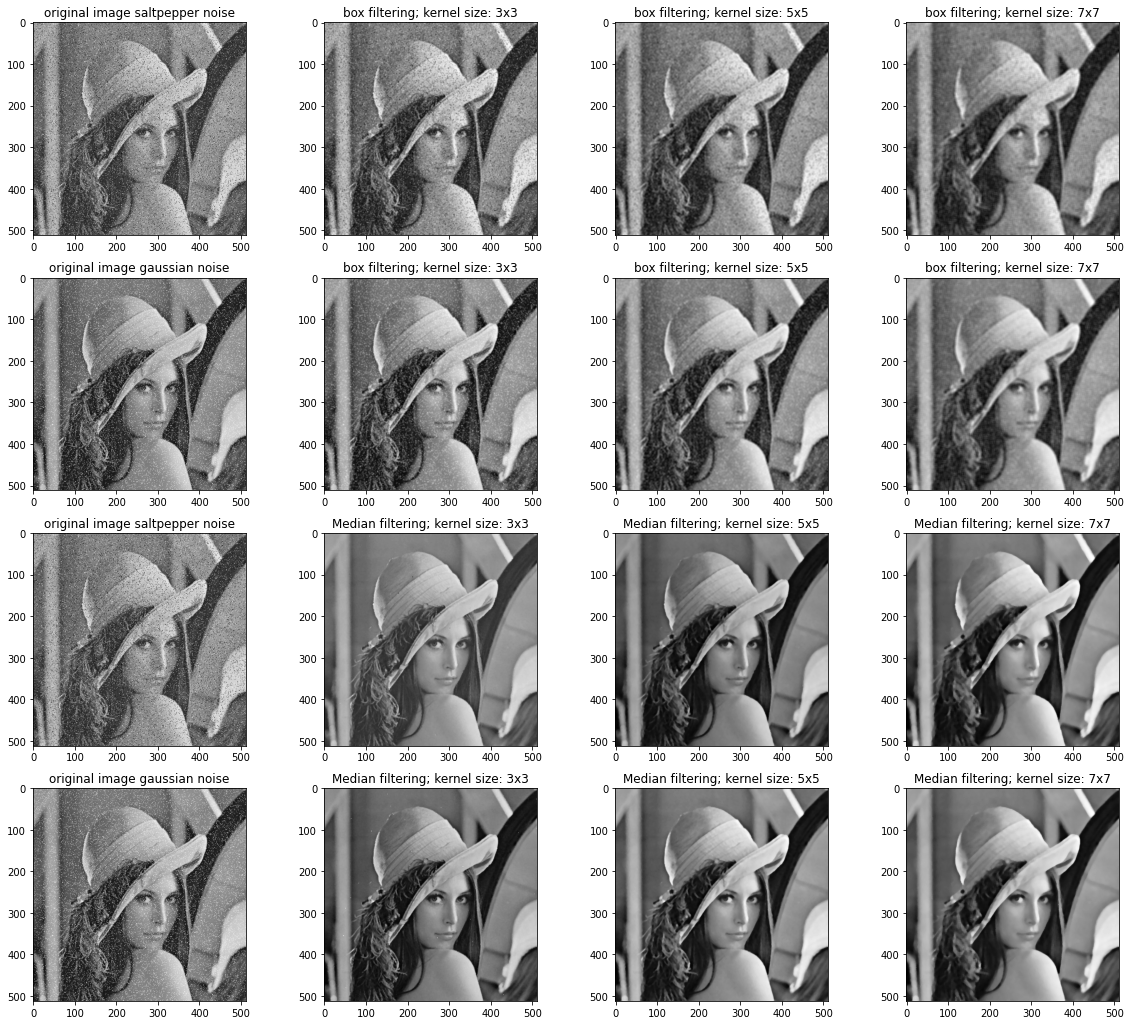

In [18]:
img1_saltpepper = cv2.imread('.\sample_data\sample_data\image1_saltpepper.jpg', 0).astype(np.float32)
img1_gaussian = cv2.imread('.\sample_data\sample_data\image1_gaussian.jpg', 0).astype(np.float32)

fig, axs = plt.subplots(4, 4, figsize=(20, 18))
for i in [0, 2]:
    axs[i, 0].imshow(img1_saltpepper, 'gray')
    axs[i, 0].set_title('original image saltpepper noise')
    axs[i+1, 0].imshow(img1_gaussian, 'gray')
    axs[i+1, 0].set_title('original image gaussian noise')
for i in range(1, 4):
    axs[0, i].imshow(denoise(img1_saltpepper, kernel_type='box' ,ksize=2*i+1), 'gray')
    axs[1, i].imshow(denoise(img1_gaussian, kernel_type='box' ,ksize=2*i+1), 'gray')
    axs[0, i].set_title("box filtering;"+" kernel size: "+str(2*i+1)+"x"+str(2*i+1))
    axs[1, i].set_title("box filtering;"+" kernel size: "+str(2*i+1)+"x"+str(2*i+1))
for i in range(1, 4):
    axs[2, i].imshow(denoise(img1_saltpepper, kernel_type='median' ,ksize=2*i+1), 'gray')
    axs[2, i].set_title("Median filtering;"+" kernel size: "+str(2*i+1)+"x"+str(2*i+1))
    axs[3, i].imshow(denoise(img1_gaussian, kernel_type='median' ,ksize=2*i+1), 'gray')
    axs[3, i].set_title("Median filtering;"+" kernel size: "+str(2*i+1)+"x"+str(2*i+1))

2.   Using your implemented function **myPSNR**, compute the PSNR for every denoised image (12 in total) wrt the original image. What is the effect of the filter size on the PSNR? Report the results (in a table) and discuss.

|            | Box  | Median  | Box  | Median | Box  | Median  |
|:----------:|:-------------:|:----------------:|:-------------:|:----------------:|:-------------:|:----------------:|
|            | 3x3           |     3x3         | 5x5           |       5x5         | 7x7           |   7x7           |
| Gaussian   |  17.91553718   |  17.27587094    |  17.47358766   |     17.15301145    |  17.27213932     |    17.06238708    |
| Saltpepper |   16.04101352    |     15.58012982     |  15.63694298    |    15.48873614    |  15.47815833    |     15.42597737|


In our case, PSNR decreasese when window size of the filter increases. This is because when applied with a larger filter nize the MSE value decreases. When filter size is larger, both filters include more pixels from a larger neighbourhood and we can expect that more different information from the center pixel is included together and my introduce errors and bias to the filtered pixel. Therefore, MSE is expected to increase, in turn, PSNR is decreased.

In [19]:
img1_saltpepper = cv2.imread('.\sample_data\sample_data\image1_saltpepper.jpg', 0).astype(np.float32)
img1_gaussian = cv2.imread('.\sample_data\sample_data\image1_gaussian.jpg', 0).astype(np.float32)
PSNR_box_saltpepper = np.array([myPSNR(img1_saltpepper, 
                                       denoise(img1_saltpepper, kernel_type='box', ksize=2*i+3)) for i in range(3)])
PSNR_box_gaussian = np.array([myPSNR(img1_gaussian, 
                                       denoise(img1_gaussian, kernel_type='box', ksize=2*i+3)) for i in range(3)])
PSNR_median_saltpepper = np.array([myPSNR(img1_saltpepper, 
                                       denoise(img1_saltpepper, kernel_type='median', ksize=2*i+3)) for i in range(3)])
PSNR_median_gaussian = np.array([myPSNR(img1_gaussian, 
                                       denoise(img1_gaussian, kernel_type='median', ksize=2*i+3)) for i in range(3)])

3.   Which is better for the salt-and-pepper noise, box or median filters? Why? What about the Gaussian noise?


<span style="color:red">Answer: </span>Visually, for salt-and-pepper noise, median filter with kernel size of 3x3 seems the the best. For Gaussian noise, median filter with kernel size of 5x5 seems the best. For both types of noises in the example picture, median filter is better than box filter. Emperically, the PSNR for the denoised image with these the filters of the above window size is the closest to the PSNR between the actual noise and the original image. This provides another proof that median filters outperforms box filters.

Explanation: Box filter takes the average of the pixel values in the filter window. However, average is more sensitive to the extreme values (hot pixels and dark pixels, especially salt and pepper noise), this means the extreme values can influence the filtered value causing it to deviate from its original value too much, therefore, the picture looks more blurred (grayed). However, median filter does not take it into account the extreme values but the median representation of the pixel values, which is a better substitution of a pixel value on average. 



4.   Try denoising image1_gaussian.jpg using a Gaussian filtering. Choose an appropriate window size and standard deviation and justify your choice. Show the denoised images in the cell below.


<span style="color:red">Answer: </span>In Gaussian filtering, a proper window size is depended on the chosen standard deviation. Gaussian distribution most values (99%) distributed between $[\mu - 3\sigma, \mu + 3\sigma]$. Conceptually, we may say that the smallest feature in the image can fit within the filter the 99% confidence interval. Fitting the feature in will help to increase the denoising quality. Hence, the interval approximatly is as wide as $6*sigma$. For pixel size is always integer, the filter size therefore is $2* floor(3*sigma) + 1$. Therefore, what we could do is to find different window size and correspondingly their most proper standard deviation, and pick the best filter by visualization (see the cell below). 

Visually, Gaussian filter with window size 7 gives the best denoising result as the noises are removed more than other filters but the image is not too blurred either. Moreover, it is more sensible to assume that sigma is 1 as it is the most often chosen sigma in Gaussian noises (white noises). Visualization is on the first row, third column in the visualization below.

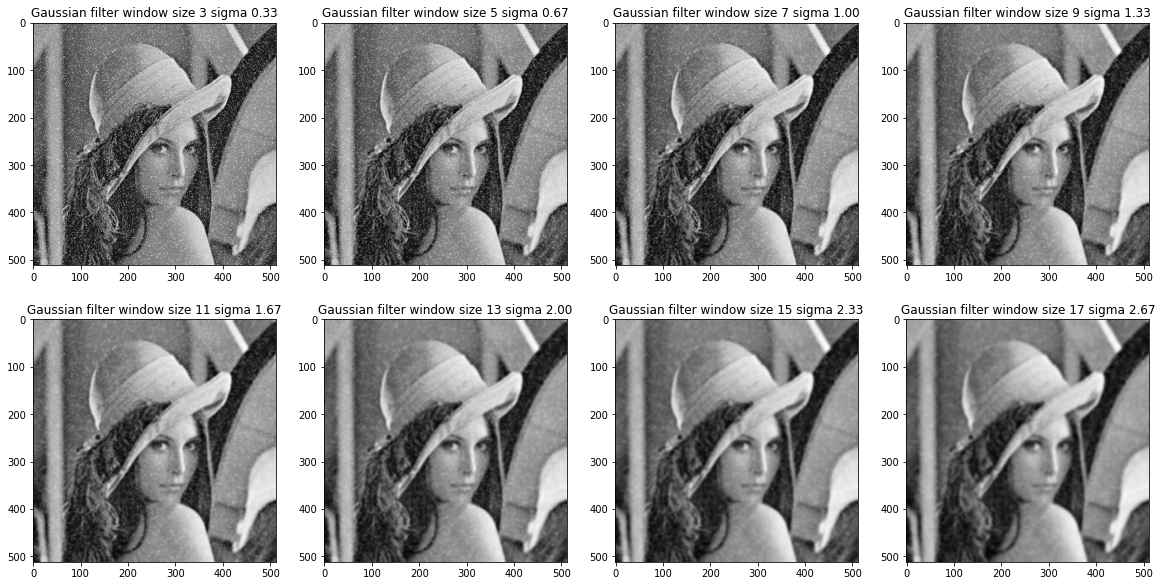

In [20]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
ksizes = np.array([[(i*4+j)*2+3 for j in range(4)]for i in range(2)])
sigmas = np.array([[(size-1)/6 for size in row] for row in ksizes])
for i in range(2):
    for j in range(4):
        sigma = sigmas[i, j]
        ksize = ksizes[i, j]
        axs[i, j].imshow(denoise(img1_gaussian, kernel_type='gaussian', ksize=ksize, sigmaX=sigma, sigmaY=sigma), 'gray')
        axs[i, j].set_title("Gaussian filter window size {} sigma {:.2f}".format(ksize, sigma))


5.   What is the effect of the standard deviation on the PSNR? Report the results (in a table) and discuss.


| $\sigma$ 	| 0.33 (size 3)	| 0.67 (size 5) 	| 1 (size 7)	| 1.33 (size 9) 	| 1.67 (size 11)	| 2 (size 13)	| 2.33 (size 15)	| 2.67 (size 17)	|
|---	|---	|---	|---	|---	|---	|---	|---	|---	|
| PSNR 	| 43.80 	|  	20.31| 18.01 	| 17.30	|  16.93	| 	16.67  	| 16.48  |  16.32	|

The value of PSNR decreases as the standard deviation increases. Using our method, a lower standard deviation associated with its smaller window size cover less pixels in the neighbor hood and do not offer much variations compared to the original pixel value of the center pixel. This means that not only neighbour pixels are less but they also have less influence on the filtered value. When standard deviation is lower, less noise may be removed (filtered pixel value is close to the original value) and therefore the image after filtering will be mostly unchanged. This causes MSE between the orignal and processed images very small and in turn increased PSNR. On the contrary, a high standard deviation leads to high MSE and therefore a high PSNR that is more close to the PSNR from using box filter.

In [21]:
# codes to compute above values
ksizes = np.array([[(i*4+j)*2+3 for j in range(4)]for i in range(2)])
sigmas = np.array([[(size-1)/6 for size in row] for row in ksizes])
results = np.zeros([2, 4])
for i in range(2):
    for j in range(4):
        sigma = sigmas[i, j]
        ksize = ksizes[i, j]
        results[i, j] = myPSNR(denoise(img1_gaussian, 
                                       kernel_type='gaussian', 
                                       ksize=ksize, sigmaX=sigma, sigmaY=sigma), img1_gaussian)


6.   What is the difference among median filtering, box filtering and Gaussian filtering? Briefly explain how they are different at a conceptual level. If two filtering methods give a PSNR in the same ballpark, can you see a qualitative difference?

<span style="color:red">Answer: </span>Median filter uses the most frequent value in the window and ignores extreme values when smoothing (removing noises from) the image, while box filter and Gaussian are more influenced by the outlier values in the filter window when taking the average (and weight average for Gaussian). This causes the denoising effect less satisfactory for Gaussian and box filter (noises are not removed and images are easily blurred). This can be seen from the values of PSNR too (median filter gives the highest PSNR when using the proper parameters). 

There can be large qualitative difference even if PSNR values are quite similar. From the tables above, we can see that that PSNR value do not differ very much for the different filters while the visualizations clearly have quality ranks. Median filter removes almost all the Gaussian or salt-and-pepper noises without blurring the image while the other two filters failed both.

## 4.3 Edge detection

Edges appear when there is a sharp change in brightness. In an image this usually corresponds to the boundaries of an object. Edge detection is a fundamental task used in many computer vision applications. One of them is road detection in autonomous driving, which is used for determining the vehicle trajectory.

Many different techniques exist for computing the edges. In this section, we will focus on filters that extract the gradient of the image. We will try to detect the road in an still image.

### 4.3.1 First-order derivative filters


**Sobel** kernels approximate the first derivative of a Gaussian filter. Below are the Sobel kernels used in the $x$ and $y$ directions.

\begin{equation}
\begin{array}{rl}
G_x = \begin{bmatrix} +1 & 0 & -1 \\ +2 & 0 & -2 \\ +1 & 0 & -1 \end{bmatrix} * \mathbf{I}
\end{array}
\end{equation}

\begin{equation}
\begin{array}{rl}
G_y = \begin{bmatrix} +1 & +2 & +1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix} * \mathbf{I}
\end{array}
\end{equation}
The gradient magnitude is defined as the square root of the sum of the squares of the horizontal ($G_x$) and the vertical ($G_y$) components of the gradient of an image, such that: 
\begin{equation}
G =\sqrt {{G_x}^2+{G_y}^2}
\end{equation}
The gradient direction is calculated as follows:
\begin{equation}
\theta= \tan ^{ - 1}{\frac{G_y}{G_x}}
\end{equation}


### Question (10 pts)
Using your implemented function **compute_gradient** on image2.jpg, display the following figures:

  1. The gradient of the image in the x-direction.

  2. The gradient of the image in the y-direction.

  3. The gradient magnitude of each pixel.

  4. The gradient direction of each pixel.

Discuss what kind of information every image conveys.



<span style="color:red">Answer: </span>The x-direction gradient shows the vertical edges of the image.

The y-direction gradient shows the horizontal edges of the image.

The gradient magnitude shows us how quickly the image is changing.

The gradient direction shows us the direction in which the change is happening.

### Exercise

Implement **compute_gradient**

**Note:** 
You are not allowed to use the Python built-in functions for computing gradient. But for doing 2D convolution, you can benefit from *scipy.signal.convolve2d* function.

In [22]:
def compute_gradient(image):
    filter_x = np.array([[1, 0, -1], 
                         [2, 0, -2], 
                         [1, 0, -1]])
    
    filter_y = np.array([[1, 2, 1],
                         [0, 0, 0],
                         [-1, -2, -1]])
    
    Gx = convolve2d(image, filter_x, 'same', 'symm')
    Gy = convolve2d(image, filter_y, 'same', 'symm')
    
    im_magnitude = np.sqrt(Gx**2 + Gy**2)
    im_direction = np.arctan(Gy/Gx)
    
    return Gx, Gy, im_magnitude, im_direction

C:\Users\tsats\anaconda3\envs\cv1\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\tsats\anaconda3\envs\cv1\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


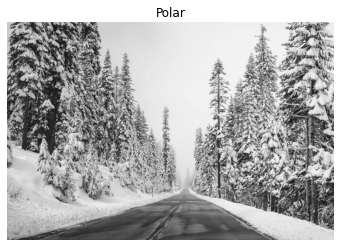

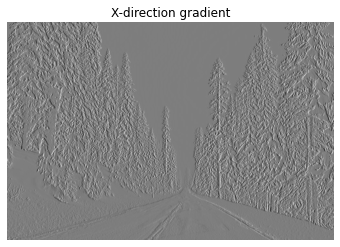

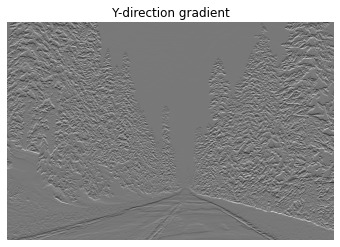

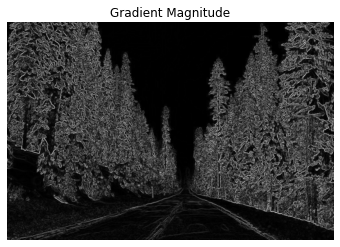

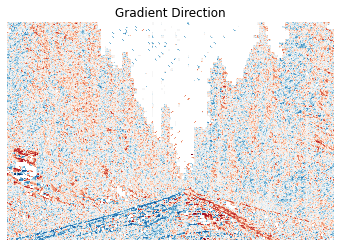

In [23]:
img = cv2.imread('./sample_data/sample_data/image2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (0, 0), fx=1, fy=1)
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

Gx, Gy, magnt, direction = compute_gradient(img)
show_image(img)
show_image(Gx, "X-direction gradient")
show_image(Gy, "Y-direction gradient")
show_image(magnt, "Gradient Magnitude")
show_image(direction, "Gradient Direction", cmap='RdBu')

### 4.3.2 Second-order derivative filters

Compared to the Sobel filter, a Laplacian of Gaussian (LoG) relies on the second derivative of a Gaussian filter. Hence, it will focus on large gradients in the image. A LoG can be computed by the following three methods:



*   method 1: Smoothing the image with a Gaussian kernel (kernel size of 5 and standard deviation of 0.5), then taking the Laplacian of the smoothed image (i.e. second derivative).
*   method 2: Convolving the image directly with a LoG kernel (kernel size of 5 and standard deviation of 0.5).

*   method 3: Taking the Difference of two Gaussians (DoG) computed at different scales $\sigma_1$ and $\sigma_2$.





### Exercise 

Implement **compute_LoG**

The function should be able to apply any of the above mentioned methods depending on the value passed to the parameter *LOG_type*

**Note:** 
You are not allowed to use the Python built-in functions for computing LOG kernels. But for doing 2D convolution, you can benefit from *scipy.signal.convolve2d* function.

In [24]:
def compute_LoG(image, LOG_type):

    if LOG_type == 1:
        #method 1
        kernel = gauss2D(0.5, 0.5, 5)
        im_gaussian = convolve2d(image, kernel, 'same', 'symm')
        laplacian = np.array([[0,1,0],
                              [1,-4,1],
                              [0,1,0]])
        imOut = convolve2d(im_gaussian, laplacian, 'same', 'symm')


    elif LOG_type == 2:
        #method 2
        LoG_kernel = np.array([[0,0,1,0,0],
                              [0,1,2,1,0],
                              [1,2,-16,2,1],
                              [0,1,2,1,0],
                              [0,0,1,0,0]])
#         LoG_kernel = np.fromfunction(lambda x,y: LoG_value(0.5, x, y), (5,5))
#         LoG_kernel = np.empty((5,5))
#         for i in range(5): # size of 5
#             for j in range(5):
#                 LoG_kernel[i,j] = LoG_value(0.5, (i-(5-1)/2),(j-(5-1)/2))
        imOut = convolve2d(image, LoG_kernel, 'same', 'symm')

    elif LOG_type == 3:
        #method 3
        sigma1 = 1
        sigma2 = 1.6
        G1 = gauss2D(sigma1, sigma1, 5)
        G2 = gauss2D(sigma2, sigma2, 5)
        imOut = convolve2d(image, G1, 'same', 'symm')-convolve2d(image, G2, 'same', 'symm')
        
    return imOut

### Questions (10 pts)

1.   Test your function using image2.jpg and visualize your results using the three methods.





Gx: [[2.63865083e-04]
 [1.06450772e-01]
 [7.86570726e-01]
 [1.06450772e-01]
 [2.63865083e-04]]
Gy: [[2.63865083e-04 1.06450772e-01 7.86570726e-01 1.06450772e-01
  2.63865083e-04]]
Gx: [[0.05448868]
 [0.24420134]
 [0.40261995]
 [0.24420134]
 [0.05448868]]
Gy: [[0.05448868 0.24420134 0.40261995 0.24420134 0.05448868]]
Gx: [[0.12857519]
 [0.23100778]
 [0.28083404]
 [0.23100778]
 [0.12857519]]
Gy: [[0.12857519 0.23100778 0.28083404 0.23100778 0.12857519]]


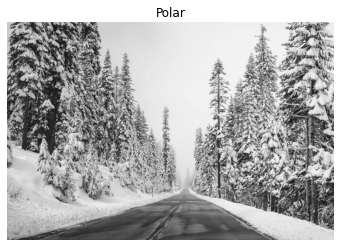

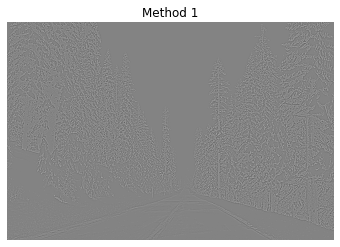

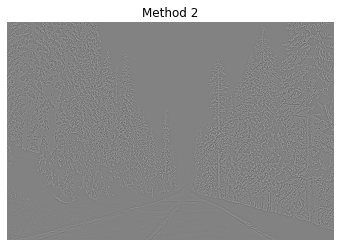

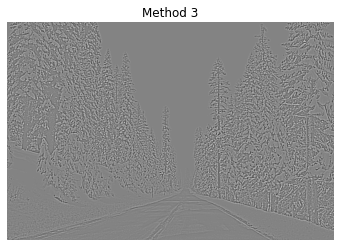

In [25]:
img = cv2.imread('./sample_data/sample_data/image2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (0, 0), fx=1, fy=1)
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

imOut = compute_LoG(img, 1)
imOut1 = compute_LoG(img, 2)
imOut2 = compute_LoG(img, 3)

show_image(img)
show_image(imOut, "Method 1")
show_image(imOut1, "Method 2")
show_image(imOut2, "Method 3")


2.   Discuss the difference between applying the three methods.


YOUR ANSWER HERE

The first method of applying Gaussian smoothing, before convolving with a discrete approximation of a Laplacian filter, is efficient and fairly resistant to noise. The Gaussian pre-processing step reduces the high frequency noise components prior to the differentiation step.

By directly applying the 5x5 Laplacian of Gaussian kernel, we are running into the problem of noise. The filter performs poorly and does not estimate edges as clearly as with the Gaussian smoothing or by using DoG.

The benefit of approximating LoG by Difference of Gaussians is that, we can calculate LoG approximations for a range of sigmas, by storing the Gaussian functions at different σ, and experiment on the best difference suited to our task. This approach also reduces the computational cost involved in experimenting across different LoG kernels.


3.   In the first method, why is it important to convolve an image with a Gaussian before convolving with a Laplacian?



Because the Laplacian is approximating the second derivative on the image, it is very sensitive to noise. To counter this, the image is smoothed with a Gaussian before applying the Laplacian filter. This pre-processing step reduces the high frequency noise components prior to the differentiation step.

4.   In the third method, what is the best ratio between $\sigma_1$ and $\sigma_2$ to achieve the best approximation of the LoG? What is the purpose of having 2 standard deviations?



A ratio of $\sigma_1$ and $\sigma_2$ of 1:1.6 is said to best approximate the 2nd derivative Laplacian of Gaussian function.

The purpose of having 2 standard deviations $\sigma_1$ and $\sigma_2$ is to approximate the Laplacian of a Gaussian with more accuracy and flexibility. The Difference of Gaussian is a tunable band-pass filter, whereas the LoG is not tunable in that same way. The DoG appears naturally in the scale-space setting, where the image is filtered at many scales (Gaussians with different sigmas), with the difference between subsequent scales is a DoG.

5.   What else is needed to improve the performance and isolate the road,  i.e. what else should be done? You don't have to provide any specific parameter or specific algorithm. Try to propose a direction which would be interesting to explore and how you would approach it.


To isolate the road, the algorithm should be less influenced by other details. One direction could be develop a filter that is more sensitive to sharp changes caused by smoothier edges in the image (such as the road edge) instead of other irelavant small details or noises. For example, we could simply threshold the LoG output at a proper value to filter changes caused the irrelavant small details, to produce a binary image where the boundaries between foreground and background regions represent the road edge.

## 4.4 Foreground-background separation

Foreground-background separation is an important task in the field of computer vision (see Figure). In this exercise, you will implement a simple unsupervised algorithm that leverages the variations in texture to segment the foreground object from the background. We will assume the foreground object has a distinct combination of textures compared to background. As mentioned earlier, Gabor filters are well-suited for texture analysis thanks to their frequency domain characteristics. Therefore, we will use a collection of Gabor filters with varying scale and orientations which we call a *filter bank*. The outline of the algorithm is as follows:

![](https://drive.google.com/uc?export=view&id=1w60xJ4UlG60Ie6ljRkHn0GJDdVu9eb5e)

**(Left)** Input image, **(Middle)** Foreground mask, **(Right)** Masked object. Foreground-Background separation aims at masking out the salient object pixels from the background pixels.

---

**Algorithm 1** Foreground-Background Segmentation Algorithm

---

**Input:** $x$ - input image

**Output:** $y$ - pixelwise labels



1.   Convert to grayscale if necessary.

>>**if** $x$ is RGB **then**

>>>$x$ $\leftarrow$ rgb2gray($x$)

>>**end if**

2.   Create Gabor filterbank, $\mathcal{F}_{gabor}$, with varying $\sigma$, $\lambda$ and $\theta$.

3.   Filter $x$ with the filterbank. Store each output in $fmaps$.

4.   Compute the magnitude of the complex $fmaps$. Store the results in $fmags$.

>>$fmags$ $\leftarrow$  $\vert fmaps \vert$

5.   Smooth $fmags$.

>>$fmags$ $\leftarrow$  smooth($fmags$)

6.   Convert $fmags$ into data matrix, $f$.

>>$f$ $\leftarrow$  reshape($fmags$)

7.   Cluster $f$ using kmeans into two sets.

>>$y$ $\leftarrow$  kmeans($f$, 2)

---


### Questions (20 pts)

1.   Run the algorithm on all test images with the provided parameter settings. What do you observe? Explain shortly.


With the given default parameters, pictures Polar, Robin-1, Robin-2 and Sciencepark are segemented reasonably well, the forground object is successfully splitted from the background. 

However, in picture Kobi, the dark dots on tiles and shadow of the dog in the background are also segemented into the forground object (dog) class. Besides, the calf in image Cows is segemented in the background instead of with the larger cow, this is not ideal either.


2.   Experiment with different $\lambda$, $\sigma$ and $\theta$ settings until you get reasonable outputs. Report what parameter settings work better for each input image and try to explain why.

>**Hint:** 
Don't change multiple variables at once. You might not need to change some at all.



We tried varying the minimum and maximum of $\lambda$ and $\theta$ and the values in $\sigma$ for image Cows and Kobi. 

However, the segementation result did not improve for image Cows compared to the default setting. 

For Kobi image, changing wavelength $\theta$ did not bring improvement, so as the step size $theta$. However, increasing the standard deviation from 1 and 2 to [1.5, 3, 4.5, 6] helped to split the dog more from the background. However, there is still a part of the tiles classified with the dog (on his left) and the top of his head is blended in the background.

3.   After you achieve good separation on all test images, run the script again with corresponding parameters but this time with

>>>smoothingFlag = False

>Describe what you observe at the output when smoothing is not applied on the magnitude images. Explain why it happens and try to reason about the motivation behind this step.

We use the default parameters for the rest images except for image Kobi with the the parameters mentioned in the above answer. No significant differences can be observed by setting the smoothing option to false. The intuition of smoothing is to increase the segementation quality. A gaussian kernel is applied if smoothing is set to True, this kernel will help to blur/smooth the image so the sections with similar texture can become even more consistent and smooth. This unsupervised algorithm is based on the assumption that we can seperate the forground and backgrond with the differences in their texture. By making the 2 sections more consistent within itself, this will both decrease the time complexity and increase the chance for k-means algorithm to see the difference more accurately. 

### Exercise

Please get yourself familiar with provided skeleton code **gabor_segmentation**.py. Keep in mind that you will need your implementation of the **createGabor** function.

When you succesfully implement it all, it should run without problems and produce a reasonable segmentation with the default parameters on **kobi.png**.

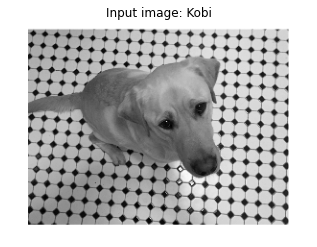

In [26]:
image_id = "Kobi"
img = load_image(image_id)

show_image(img, f'Input image: {image_id}')


--------------------------------------
 		Details
--------------------------------------
Total number of filters       : 120
Number of scales (sigma)      : 4
Number of orientations (theta): 5
Number of carriers (lambda)   : 6
---------------------------------------
Filter bank created in 0.02692866325378418 seconds.
---------------------------------------


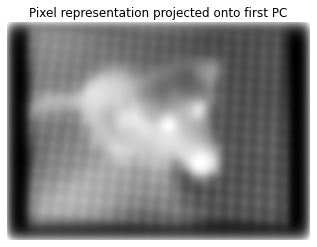

Clustering completed in 7.317771911621094 seconds.


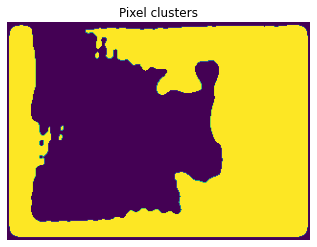

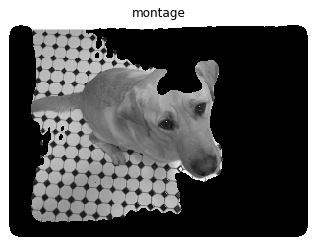

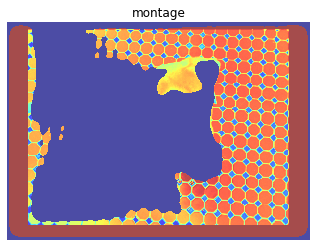

In [27]:
# Control settings
visFlag       = False    #  Set to true to visualize filter responses.
smoothingFlag = False   #  Set to true to postprocess filter outputs.

# Design array of Gabor Filters
# In this code section, you will create a Gabor Filterbank. A filterbank is
# a collection of filters with varying properties (e.g. {shape, texture}).
# A Gabor filterbank consists of Gabor filters of distinct orientations
# and scales. We will use this bank to extract texture information from the
# input image. 

numRows, numCols = img.shape

# Estimate the minimum and maximum of the wavelengths for the sinusoidal
# carriers. 
# ** This step is pretty much standard, therefore, you don't have to
#    worry about it. It is cycles in pixels. **   
lambdaMin = 4/np.sqrt(2)
lambdaMax = np.sqrt(abs(numRows)**2 + abs(numCols)**2)

# Specify the carrier wavelengths.  
# (or the central frequency of the carrier signal, which is 1/lambda)
n = np.floor(np.log2(lambdaMax/lambdaMin))
lambdas = 2**np.arange(0, (n-2)+1) * lambdaMin

# Define the set of orientations for the Gaussian envelope.
dTheta       = 2 * np.pi/8                  # \\ the step size
orientations = np.arange(0, np.pi+dTheta, dTheta)        

# Define the set of sigmas for the Gaussian envelope. Sigma here defines 
# the standard deviation, or the spread of the Gaussian. 
sigmas = np.array([1.5, 3, 4.5, 6])


# Now you can create the filterbank. We provide you with a Python list
# called gaborFilterBank in which we will hold the filters and their
# corresponding parameters such as sigma, lambda and etc. 
# ** All you need to do is to implement createGabor(). Rest will be handled
#    by the provided code block. **
gaborFilterBank = []
tic = time.time()
for lmbda in lambdas:
    for sigma in sigmas:
        for theta in orientations:
            # Filter parameter configuration for this filter.
            psi    = 0
            gamma  = 0.5
            
            # Create a Gabor filter with the specs above. 
            # (We also record the settings in which they are created. )
            filter_config = {}
            filter_config["filterPairs"] = createGabor( sigma, theta, lmbda, psi, gamma )
            filter_config["sigma"]       = sigma
            filter_config["lmbda"]       = lmbda
            filter_config["theta"]       = theta
            filter_config["psi"]         = psi
            filter_config["gamma"]       = gamma
            gaborFilterBank.append(filter_config)
ctime = time.time() - tic

print('--------------------------------------\n \t\tDetails\n--------------------------------------')
print(f'Total number of filters       : {len(gaborFilterBank)}')
print(f'Number of scales (sigma)      : {len(sigmas)}')
print(f'Number of orientations (theta): {len(orientations)}')
print(f'Number of carriers (lambda)   : {len(lambdas)}')
print(f'---------------------------------------')
print(f'Filter bank created in {ctime} seconds.')
print(f'---------------------------------------')

# Filter images using Gabor filter bank using quadrature pairs (real and imaginary parts)
# You will now filter the input image with each complex Gabor filter in 
# gaborFilterBank structure and store the output in the cell called 
# featureMaps. 
# // Hint-1: Apply both the real imaginary parts of each kernel 
#            separately in the spatial domain (i.e. over the image). //
# // Hint-2: Assign each output (i.e. real and imaginary parts) in
#            variables called real_out and imag_out. //
# // Hint-3: Use built-in cv2 function, filter2D, to convolve the filter
#            with the input image. Check the options for padding. Find 
#            the one that works well. You might want to
#            explain what works better and why shortly in the report.
featureMaps = []

for gaborFilter in gaborFilterBank:
    # gaborFilter["filterPairs"] has two elements. One is related to the real part 
    # of the Gabor Filter and the other one is the imagineray part.
    real_out = convolve2d(img, gaborFilter["filterPairs"][...,0], mode='same') # \\TODO: completed
    imag_out = convolve2d(img, gaborFilter["filterPairs"][...,1], mode='same') # \\TODO: completed
    featureMaps.append(np.stack((real_out, imag_out), 2))
    
    # Visualize the filter responses if you wish.
    if visFlag:
        fig = plt.figure()

        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(real_out)    # Real
        title = "Re[h(x,y)], \n lambda = {0:.4f}, \n theta = {1:.4f}, \n sigma = {2:.4f}".format(gaborFilter["lmbda"], gaborFilter["theta"], gaborFilter["sigma"])
        ax.set_title(title)
        ax.axis("off")

        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(imag_out)    # Real
        title = "Im[h(x,y)], \n lambda = {0:.4f}, \n theta = {1:.4f}, \n sigma = {2:.4f}".format(gaborFilter["lmbda"], gaborFilter["theta"], gaborFilter["sigma"])
        ax.set_title(title)
        ax.axis("off")
        plt.show()

# Compute the magnitude
# Now, you will compute the magnitude of the output responses.
# \\ Hint: (real_part^2 + imaginary_part^2)^(1/2) \\
featureMags = []
for i, fm in enumerate(featureMaps):
    real_part = fm[...,0]
    imag_part = fm[...,1]
    mag = np.sqrt(real_part**2 + imag_part**2)  # \\TODO: completed
    featureMags.append(mag)
    
    # Visualize the magnitude response if you wish.
    if visFlag:
        fig = plt.figure()

        ax = fig.add_subplot(1, 1, 1)
        ax.imshow(mag.astype(np.uint8))    # visualize magnitude
        title = "Re[h(x,y)], \n lambda = {0:.4f}, \n theta = {1:.4f}, \n sigma = {2:.4f}".format(gaborFilterBank[i]["lmbda"], 
                                                                                                 gaborFilterBank[i]["theta"], 
                                                                                                 gaborFilterBank[i]["sigma"])
        ax.set_title(title)
        ax.axis("off")

# Prepare and Preprocess features 
# You can think of each filter response as a sort of feature representation
# for the pixels. Now that you have numFilters = |gaborFilterBank| filters, 
# we can represent each pixel by this many features. 
# \\ Q: What kind of features do you think gabor filters might correspond to? 

# You will now implement a smoothing operation over the magnitude images in
# featureMags. 
# \\ Hint: For each i in [1, length(featureMags)], smooth featureMags{i}
#          using an appropriate first order Gaussian kernel.
# \\ Hint: cv2 filter2D function is helpful here.   
features = np.zeros(shape=(numRows, numCols, len(featureMags)))
if smoothingFlag:
    # \\TODO:
    #FOR_LOOP
        # i)  filter the magnitude response with appropriate Gaussian kernels
        # ii) insert the smoothed image into features[:,:,j]
    #END_FOR
    kernel = gauss2D(1, 1, 3)
    for j in range(features.shape[2]):
        features[...,j] = convolve2d(np.float64(featureMags[j]), kernel, mode='same')
else:
    # Don't smooth but just insert magnitude images into the matrix
    # called features.
    for i, fmag in enumerate(featureMags):
        features[:,:,i] = fmag


# Reshape the filter outputs (i.e. tensor called features) of size 
# [numRows, numCols, numFilters] into a matrix of size [numRows*numCols, numFilters]
# This will constitute our data matrix which represents each pixel in the 
# input image with numFilters features.  
features = np.reshape(features, newshape=(numRows * numCols, -1))


# Standardize features. 
# \\ Hint: see http://ufldl.stanford.edu/wiki/index.php/Data_Preprocessing for more information.

features = np.reshape(features, newshape=(numRows * numCols, -1))  # \\ TODO: i)  Implement standardization on matrix called features.
                                                                            # ii) Return the standardized data matrix.


# (Optional) Visualize the saliency map using the first principal component 
# of the features matrix. It will be useful to diagnose possible problems 
# with the pipeline and filterbank.

transformed_feature = PCA(n_components=1).fit_transform(features) # select the first component
transformed_feature = np.ascontiguousarray(transformed_feature, dtype=np.float32)
feature2DImage = np.reshape(transformed_feature,newshape=(numRows,numCols))
plt.figure()
plt.title(f'Pixel representation projected onto first PC')
plt.imshow(feature2DImage, cmap='gray')
plt.axis("off") 
plt.show()

# Apply k-means algorithm to cluster pixels using the data matrix,
# features. 
# \\ Hint-1: search about sklearn kmeans function https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html.
# \\ Hint-2: use the parameter k defined in the first section when calling
#            sklearn's built-in kmeans function.
tic = time.time()
k = 2
pixLabels = KMeans(n_clusters=k, random_state=0).fit(features).predict(features)  # \\TODO: Return cluster labels per pixel
ctime = time.time() - tic
print(f'Clustering completed in {ctime} seconds.')



# Visualize the clustering by reshaping pixLabels into original grayscale
# input size [numRows numCols].
pixLabels = np.reshape(pixLabels, newshape=(numRows, numCols))
plt.figure()
plt.title(f'Pixel clusters')
plt.imshow(pixLabels)
plt.axis("off") 
plt.show()


# Use the pixLabels to visualize segmentation.
Aseg1 = np.zeros_like(img)
Aseg2 = np.zeros_like(img)
BW = pixLabels == 0  # check for the value of your labels in pixLabels (could be 1 or 0 instead of 2)
#BW = np.repeat(BW[:, :, np.newaxis], 3, axis=2) # do this only if you have 3 channels in the img
Aseg1[BW] = img[BW]
Aseg2[~BW] = img[~BW]

plt.figure()
plt.title(f'montage')
plt.imshow(Aseg1, 'gray', interpolation='none')
plt.axis("off")
plt.show()


plt.figure()
plt.title(f'montage')
plt.imshow(Aseg2, 'jet',  interpolation='none', alpha=0.7)
plt.axis("off")
plt.show()